## Purpose of this notebook:
- Provide a model that can predict the home value of single unit properties that the tax district assessed during the  months of May through August 2017, using number of bedrooms, number of bathrooms, and square feet of the property as features
- Create and evaluate different models to find the effectiveness of the selected features
- Using the FIPS numbers, find the specific county for each home in the data, and create a seperate dataframe to display the tax rate for each county



In [1]:
# imports

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm, ttest_ind, pearsonr
from math import sqrt

from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import env
import acquire
import prepare

## Acquire

In [2]:
# acquire data 

df = acquire.get_zillow_data()

In [3]:
# Take a look at the data

df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,None,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11446756,451211,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,107110.0,2016.0,46573.0,1399.27,None,NaN,6.037650e+13,2681,-0.163064,2017-08-23


In [4]:
# Print a structured shape of the original data

print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My original dataframe is coming in with 28124 rows and 62 columns.


In [5]:
# Looking at the columns with more detail

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 62 columns):
parcelid                        28124 non-null int64
id                              28124 non-null int64
airconditioningtypeid           7303 non-null float64
architecturalstyletypeid        33 non-null float64
basementsqft                    25 non-null float64
bathroomcnt                     28124 non-null float64
bedroomcnt                      28124 non-null float64
buildingclasstypeid             0 non-null object
buildingqualitytypeid           17811 non-null float64
calculatedbathnbr               28050 non-null float64
decktypeid                      213 non-null float64
finishedfloor1squarefeet        2439 non-null float64
calculatedfinishedsquarefeet    28077 non-null float64
finishedsquarefeet12            27999 non-null float64
finishedsquarefeet13            0 non-null object
finishedsquarefeet15            0 non-null object
finishedsquarefeet50            2439 non

In [6]:
# Take a look at the original max value of the features that I want adjust for outliers

df[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']].max()

calculatedfinishedsquarefeet       17245.0
taxvaluedollarcnt               23858374.0
dtype: float64

### Takeaways:
- This data set is rife with null values
- There are many redundant columns (several square footage columns, several structural columns, etc)
- There are some serious outliers that are skewing the values

## Prepare

### For prepare, I did the following:
- renamed columns to make them understandable
- dropped a total of 52 null/NAN, irrelevant, and redundant rows
- removed outliers from appraisal_value and square_feet

In [7]:
# Use the clean_zillow funtion to drop columns, drop nulls, and address outliers

df = prepare.clean_zillow(df)
df

,bathrooms,bedrooms,square_feet,fips,longitude,city,zip_code,year_built,appraisal_value,taxes
0,2.0,3.0,1316.0,6037.0,-118.355396,12447.0,95997.0,1923.0,205123.0,2627.48
1,2.0,3.0,1458.0,6037.0,-118.113100,5534.0,97318.0,1970.0,136104.0,2319.90
2,1.0,2.0,1421.0,6037.0,-118.291863,12447.0,96018.0,1911.0,35606.0,543.69
3,3.0,4.0,2541.0,6059.0,-117.912245,38032.0,96958.0,2003.0,880456.0,9819.72
4,2.0,3.0,1491.0,6037.0,-118.338253,54722.0,96162.0,1955.0,107110.0,1399.27
...,...,...,...,...,...,...,...,...,...,...
28119,2.0,6.0,2634.0,6037.0,-118.298006,12447.0,95985.0,1921.0,878190.0,12766.88
28120,1.5,4.0,1187.0,6059.0,-118.015068,16764.0,96180.0,1959.0,465999.0,5552.68
28121,3.0,5.0,3015.0,6059.0,-117.578817,13693.0,96983.0,2002.0,852813.0,11662.88
28122,3.0,5.0,2992.0,6037.0,-118.554206,12447.0,96356.0,1977.0,1120000.0,13663.03


In [8]:
# Take a look at my post-cleaning dataframe, which is much more manageable.

print(f'My cleaned dataframe is now coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My cleaned dataframe is now coming in with 24903 rows and 10 columns.


In [9]:
# Take a more detailed look at my post-cleaning dataframe. I now have 24903 rows, all columns are either float 
# or int, and no nulls

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24903 entries, 0 to 28123
Data columns (total 10 columns):
bathrooms          24903 non-null float64
bedrooms           24903 non-null float64
square_feet        24903 non-null float64
fips               24903 non-null float64
longitude          24903 non-null float64
city               24903 non-null float64
zip_code           24903 non-null float64
year_built         24903 non-null float64
appraisal_value    24903 non-null float64
taxes              24903 non-null float64
dtypes: float64(10)
memory usage: 2.1 MB


In [10]:
# Calculate the tax rate and add it as a column

df['tax_rate'] = (df['taxes'] / df['appraisal_value'])

## Deliverable: Where the Properties Are Located

In [11]:
# The FIPS code shows that the data is based on 3 counties in Southern California: Los Angeles, Orange, and Ventura 

df['fips'].unique()

array([6037., 6059., 6111.])

In [12]:
# Add the name of the county based on the FIPS numbers from the db

df['county_name'] = df['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
df

,bathrooms,bedrooms,square_feet,fips,longitude,city,zip_code,year_built,appraisal_value,taxes,tax_rate,county_name
0,2.0,3.0,1316.0,6037.0,-118.355396,12447.0,95997.0,1923.0,205123.0,2627.48,0.012809,Los Angeles
1,2.0,3.0,1458.0,6037.0,-118.113100,5534.0,97318.0,1970.0,136104.0,2319.90,0.017045,Los Angeles
2,1.0,2.0,1421.0,6037.0,-118.291863,12447.0,96018.0,1911.0,35606.0,543.69,0.015270,Los Angeles
3,3.0,4.0,2541.0,6059.0,-117.912245,38032.0,96958.0,2003.0,880456.0,9819.72,0.011153,Orange
4,2.0,3.0,1491.0,6037.0,-118.338253,54722.0,96162.0,1955.0,107110.0,1399.27,0.013064,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...
28119,2.0,6.0,2634.0,6037.0,-118.298006,12447.0,95985.0,1921.0,878190.0,12766.88,0.014538,Los Angeles
28120,1.5,4.0,1187.0,6059.0,-118.015068,16764.0,96180.0,1959.0,465999.0,5552.68,0.011916,Orange
28121,3.0,5.0,3015.0,6059.0,-117.578817,13693.0,96983.0,2002.0,852813.0,11662.88,0.013676,Orange
28122,3.0,5.0,2992.0,6037.0,-118.554206,12447.0,96356.0,1977.0,1120000.0,13663.03,0.012199,Los Angeles


## Deliverable: the Distribution of Tax Rates for Each County

In [13]:
# Showing the median tax rate per county

county_median_tax_rate = pd.DataFrame(round(df.groupby('county_name').tax_rate.median(), 3))
county_median_tax_rate.columns = ['tax_rate']
county_median_tax_rate

,tax_rate
county_name,
Los Angeles,0.013
Orange,0.012
Ventura,0.011


In [14]:
# Visualize the tax distribution by county

los_angeles_tax_dist = df[df.county_name == "Los Angeles"].tax_rate
orange_tax_dist = df[df.county_name == "Orange"].tax_rate
ventura_tax_dist = df[df.county_name == "Ventura"].tax_rate

In [15]:
los_angeles_tax_dist.describe()

count    15961.000000
mean         0.014235
std          0.009007
min          0.000857
25%          0.012189
50%          0.012747
75%          0.014591
max          0.816490
Name: tax_rate, dtype: float64

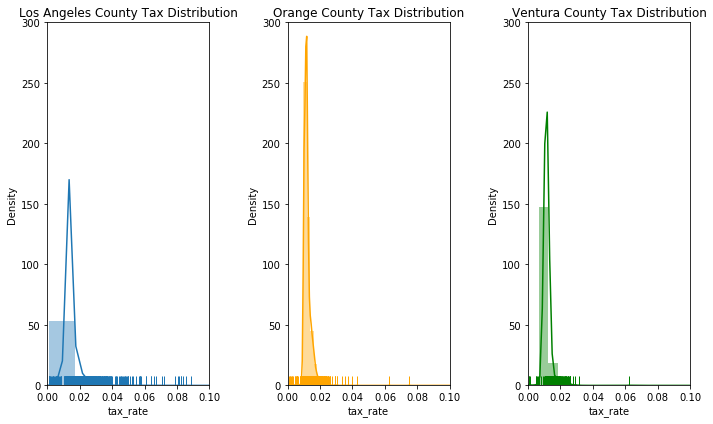

In [16]:
# Visualization showing side-by-side comparison of County Tax Rate

plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
sns.distplot(los_angeles_tax_dist, bins=50, kde=True, rug=True)
plt.xlim(0, .10)
plt.ylim(0, 300)
plt.title("Los Angeles County Tax Distribution")

plt.subplot(1,3,2)
sns.distplot(orange_tax_dist, bins=50, kde=True, rug=True, color='orange')
plt.xlim(0, .10)
plt.ylim(0, 300)
plt.title("Orange County Tax Distribution")

plt.subplot(1,3,3)
sns.distplot(ventura_tax_dist, bins=50, kde=True, rug=True, color='green')
plt.xlim(0, .10)
plt.ylim(0, 300)
plt.title("Ventura County Tax Distribution")

plt.tight_layout()

plt.show()

In [17]:
# After reviewing the pairwise correlations, I've decided on my features 

features = [
    "bedrooms",
    "bathrooms",
    "square_feet",
    "appraisal_value"
]

df = df[features]
df.head()

,bedrooms,bathrooms,square_feet,appraisal_value
0,3.0,2.0,1316.0,205123.0
1,3.0,2.0,1458.0,136104.0
2,2.0,1.0,1421.0,35606.0
3,4.0,3.0,2541.0,880456.0
4,3.0,2.0,1491.0,107110.0


In [18]:
# Take a look at 'square_feet', 'appraisal_value' with the outliers removed

df[['square_feet', 'appraisal_value']].describe()

,square_feet,appraisal_value
count,24903.000000,2.490300e+04
mean,1721.093724,3.888111e+05
std,630.290238,2.637075e+05
min,240.000000,1.000000e+03
25%,1244.000000,1.788455e+05
50%,1592.000000,3.448350e+05
75%,2101.000000,5.405470e+05
max,3533.000000,1.273707e+06


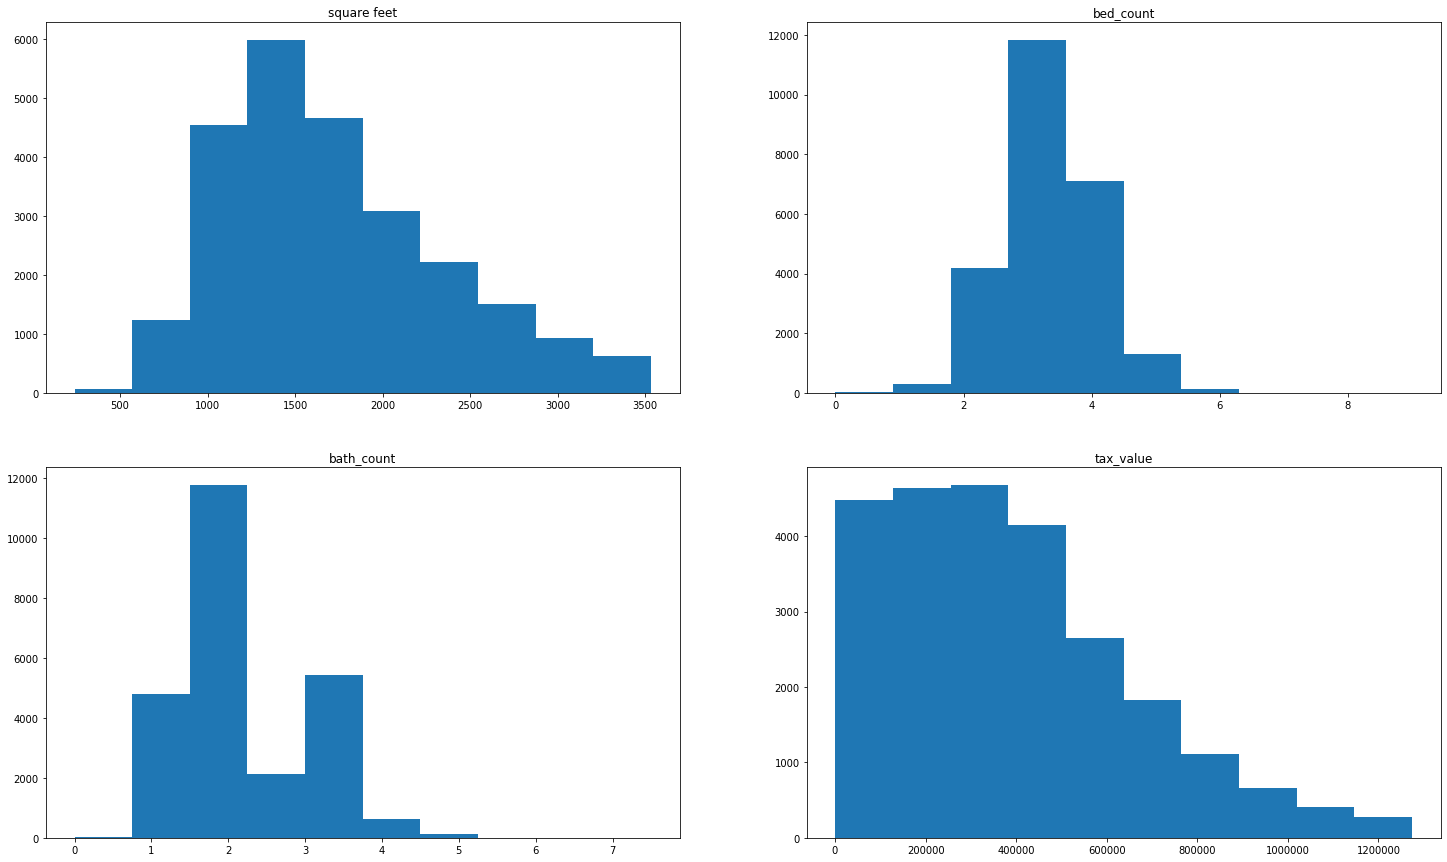

In [19]:
# Construct a figure with subplots of histograms of features

# Sets size, can adjust 
plt.subplots(figsize=(25, 15))

plt.subplot(2,2,1);
line1 = plt.hist(df.square_feet)
plt.title('square feet');

plt.subplot(2,2,2);
line2 = plt.hist(df.bedrooms);
plt.title('bed_count');

plt.subplot(2,2,3);
line3 = plt.hist(df.bathrooms);
plt.title('bath_count');

plt.subplot(2,2,4);
line3 = plt.hist(df.appraisal_value);
plt.title('tax_value');

In [20]:
# Split the data into train, validate, and test and then confirm the shape of the split sets

train, validate, test = prepare.split(df)

train shape:  (17929, 4) , validate shape:  (4483, 4) , test shape:  (2491, 4)


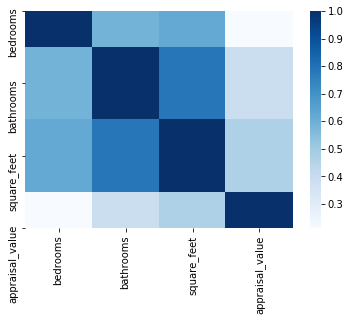

In [21]:
sns.heatmap(df.corr(),cmap="Blues")

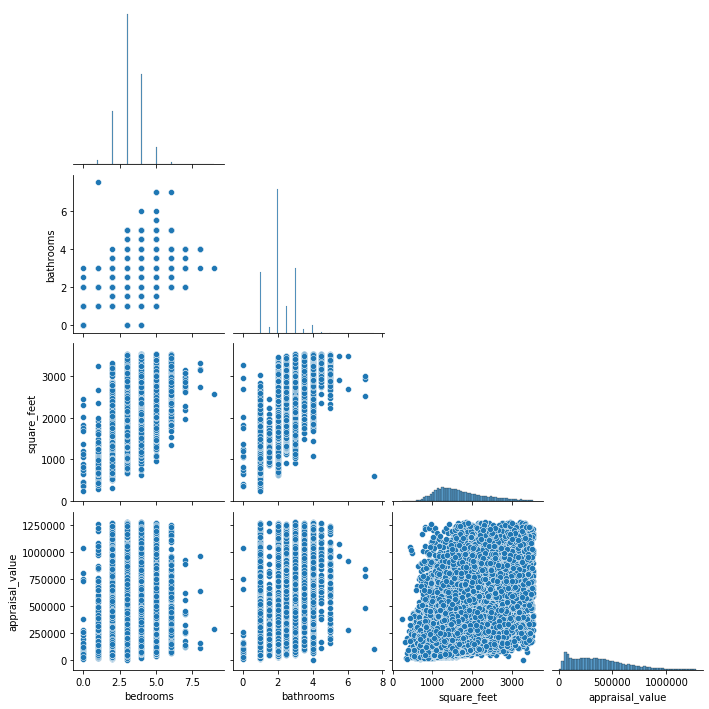

In [22]:
sns.pairplot(df, corner=True)

Text(0.5, 1.0, 'MinMax Scaled Bath Count')

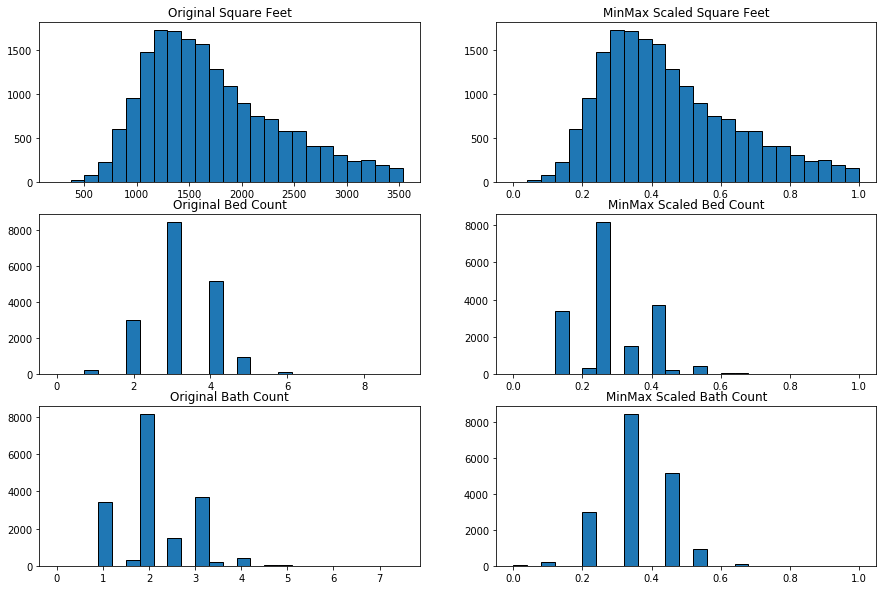

In [23]:
# Visualize the original variables versus the scaled variables

plt.figure(figsize=(15, 10))

plt.subplot(321)
plt.hist(train.square_feet, bins=25, ec='black')
plt.title('Original Square Feet')
plt.subplot(322)
plt.hist(train.square_feet_scaled, bins=25, ec='black')
plt.title('MinMax Scaled Square Feet')

plt.subplot(323)
plt.hist(train.bedrooms, bins=25, ec='black')
plt.title('Original Bed Count')
plt.subplot(324)
plt.hist(train.bedrooms_scaled, bins=25, ec='black')
plt.title('MinMax Scaled Bed Count')

plt.subplot(325)
plt.hist(train.bathrooms, bins=25, ec='black')
plt.title('Original Bath Count')
plt.subplot(326)
plt.hist(train.bathrooms_scaled, bins=25, ec='black')
plt.title('MinMax Scaled Bath Count')

### Takeaways:


## Explore

In [24]:
def plot_variable_pairs_regline(train, hue=None):
    '''
    This function takes in a df and default hue=None and displays a pairplot
    with a red regression line.
    '''
    plot_kws={'line_kws':{'color':'red'}, 
              'scatter_kws': {'alpha': 0.7}}
    sns.pairplot(train.drop(['square_feet','bedrooms','bathrooms'],axis=1), hue=hue, kind="reg", plot_kws={'line_kws':{'color':'red'}, 
                                                    'scatter_kws': {'alpha': 0.1}})

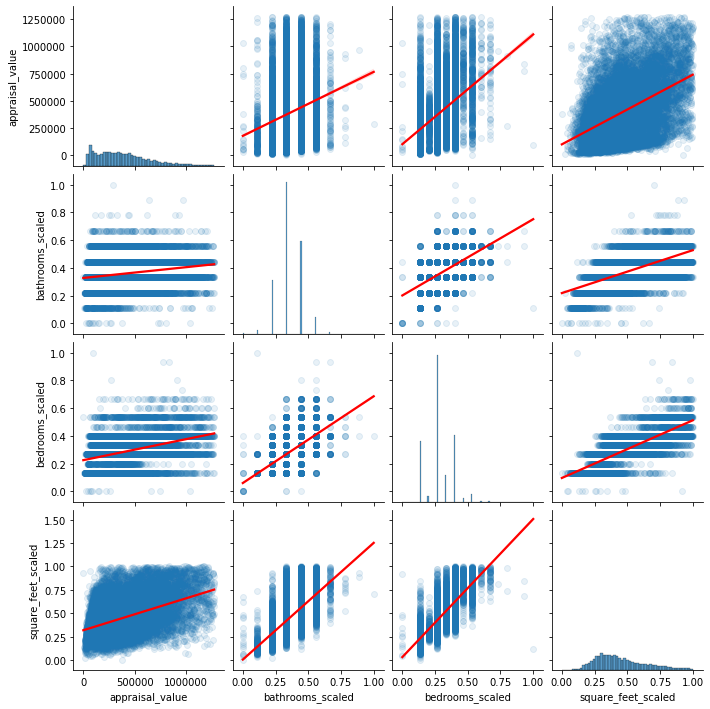

In [25]:
plot_variable_pairs_regline(train, hue=None)

### T-Test: Does the Square-footage of a home affect Tax Value?

$H_0$: The average price of homes with 3000 sq.ft. or more is equal to the average price of homes with 3000 sq.ft. or less.

$H_A$: Homes with 3000 sq.ft. or more have higher than average tax dollar count.

In [26]:
# Perform the T-Test

df_less_than_3000 = train[train.square_feet <= 3000]
df_greater_than_3000 = train[train.square_feet > 3000]

a = df_less_than_3000.appraisal_value.mean()
b = df_greater_than_3000.appraisal_value.mean()

t, p = ttest_ind(df_greater_than_3000.appraisal_value,
                df_less_than_3000.appraisal_value)

if p > a:
    print(f'''Because p ({p:.4f}) > alpha (.05), we fail to reject the Null Hypothesis''')
else:
    print(f'''Because p ({p:.4f}) < alpha (.05), we reject the Null Hypothesis''')
print(p)

Because p (0.0000) < alpha (.05), we reject the Null Hypothesis
3.1891855852129888e-301


In [27]:
# View/confirm values

df_less_than_3000.appraisal_value.mean()

374044.1247291679

In [28]:
# View/confirm values

df_greater_than_3000.appraisal_value.mean()

709520.8896713615

### Correlation Test1: Are the number of bathrooms related to the house value?

$H_0$: The number of bathrooms is independent to the value of the home 

$H_A$: The number of bathrooms is related to the value of the home

In [29]:
confidence_interval = 0.95
a = 1 - confidence_interval 

corr, p = stats.pearsonr(train.bathrooms, train.appraisal_value)
print(corr, p)

if p > a:
    print(f'''Because p ({p:.4f}) > alpha (.05), we fail to reject the Null Hypothesis''')
else:
    print(f'''Because p ({p:.4f}) < alpha (.05), we reject the Null Hypothesis''')

0.39033293286526277 0.0
Because p (0.0000) < alpha (.05), we reject the Null Hypothesis


### Correlation Test2: Are the number of bedrooms related to the house value?

$H_0$: The number of bedrooms is independent to the value of the home 

$H_A$: The number of bedrooms is related to the value of the home

In [30]:
# Perform the Correlation Test

corr, p = stats.pearsonr(train.bedrooms, train.appraisal_value)
print(corr, p)

if p > a:
    print(f'''Because p ({p:.4f}) > alpha (.05), we fail to reject the Null Hypothesis''')
else:
    print(f'''Because p ({p:.4f}) < alpha (.05), we reject the Null Hypothesis''')

0.2133255333564658 1.3660324506027073e-183
Because p (0.0000) < alpha (.05), we reject the Null Hypothesis


### Takeaways: 

## Modeling

In [45]:


X_train = train[['square_feet_scaled', 'bedrooms_scaled', 'bathrooms_scaled']]
X_validate = validate[['square_feet_scaled', 'bedrooms_scaled', 'bathrooms_scaled']]
X_test = test[['square_feet_scaled', 'bedrooms_scaled', 'bathrooms_scaled']]

y_train = train[['appraisal_value']]
y_validate = validate[['appraisal_value']]
y_test = test[['appraisal_value']]

In [46]:
# Validate that my X_train contains what I think it contains

X_train.head()

,square_feet_scaled,bedrooms_scaled,bathrooms_scaled
24547,0.559672,0.400000,0.222222
19039,0.517158,0.333333,0.333333
7093,0.525357,0.400000,0.444444
5376,0.279988,0.266667,0.333333
18772,0.504100,0.266667,0.444444


In [47]:
# Validate that my y_train contains what I think it contains

y_train.head()

,appraisal_value
24547,758666.0
19039,643944.0
7093,87346.0
5376,277670.0
18772,585000.0


In [48]:
# Establish my baseline

# 1. Compute appraisal_value_pred_mean
appraisal_value_pred_mean = y_train.appraisal_value.mean()
y_train['appraisal_value_pred_mean'] = appraisal_value_pred_mean
y_validate['appraisal_value_pred_mean'] = appraisal_value_pred_mean

# 2. Compute appraisal_value_pred_median
appraisal_value_pred_median = y_train.appraisal_value.median()
y_train['appraisal_value_pred_median'] = appraisal_value_pred_median
y_validate['appraisal_value_pred_median'] = appraisal_value_pred_median

# 3. RMSE of appraisal_value_pred_mean
rmse_train = mean_squared_error(y_train.appraisal_value, y_train.appraisal_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.appraisal_value, y_validate.appraisal_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of appraisal_value_pred_median
rmse_train = mean_squared_error(y_train.appraisal_value, y_train.appraisal_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.appraisal_value, y_validate.appraisal_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  262559.26 
Validate/Out-of-Sample:  267188.29
RMSE using Median
Train/In-Sample:  266061.64 
Validate/Out-of-Sample:  270034.5


In [51]:
# Following Madeleine's idea, I'm creating a dataframe for comparison of metrics for model selection

from sklearn.metrics import explained_variance_score

metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.appraisal_value, y_validate.appraisal_value_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,232124.425985,0.0


In [52]:
# First model: Linear Regression (OLS)

# make the thing
 
lm = LinearRegression(normalize=True)

# fit the model to our training data
# 
# fit the thing
# 
lm.fit(X_train, y_train.appraisal_value)

# predict train
# 
# use the thing!
# 
y_train['appraisal_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.appraisal_value, y_train.appraisal_value_pred_lm) ** (1/2)

# predict validate
y_validate['appraisal_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.appraisal_value, y_validate.appraisal_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  230263.49066877016 
Validation/Out-of-Sample:  232124.4259845371


In [55]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.appraisal_value, y_validate.appraisal_value_pred_lm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,232124.425985,0.000000
1,OLS Regressor,232124.425985,0.245136
2,OLS Regressor,232124.425985,0.245136
3,OLS Regressor,232124.425985,0.245136


In [56]:
# LassoLars

# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train.appraisal_value)

# predict train
y_train['appraisal_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.appraisal_value, y_train.appraisal_value_pred_lm) ** (1/2)

# predict validate
y_validate['appraisal_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.appraisal_value, y_validate.appraisal_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  230263.49066877016 
Validation/Out-of-Sample:  232124.4259845371


In [58]:
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.appraisal_value, y_validate.appraisal_value_pred_lars)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,232124.425985,0.000000
1,OLS Regressor,232124.425985,0.245136
2,OLS Regressor,232124.425985,0.245136
3,OLS Regressor,232124.425985,0.245136
4,Lasso alpha 1,232124.425985,0.245079
